# ディープニューラルネットワーク

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [2]:
# MNIST
from keras.datasets import mnist
(X, y), (X_test, y_test) = mnist.load_data()

X.shape, y.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [3]:
# 平滑化
X_flat = X.reshape(-1, 28*28)
X_test_flat = X_test.reshape(-1, 28*28)

# 型変換
X_flat = X_flat.astype(np.float)
X_test_flat = X_test_flat.astype(np.float)

# 正規化
X_flat /= 255
X_test_flat /= 255

X_flat.shape, X_test_flat.shape

C:\Users\ryoga_inaba\AppData\Local\Temp\ipykernel_18636\2702144909.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_flat = X_flat.astype(np.float)
C:\Users\ryoga_inaba\AppData\Local\Temp\ipykernel_18636\2702144909.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test_flat = X_test_flat.astype(np.float)


((60000, 784), (10000, 784))

In [4]:
# 正しいラベル値のワンホット エンコーディング
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_one_hot = enc.fit_transform(y[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

y.shape, y_one_hot.shape

C:\Users\ryoga_inaba\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((60000,), (60000, 10))

In [5]:
# トレーニング データと検証データに分割
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_flat, y_one_hot, test_size=0.2)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((48000, 784), (12000, 784), (48000, 10), (12000, 10))

## 【問題1】全結合層のクラス化

In [6]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, activation):
        
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.initializer = initializer
        self.optimizer = optimizer
        self.activation = activation
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = self.initializer.W(self.n_nodes1, self.n_nodes2)
        self.B = self.initializer.B(self.n_nodes2)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.X = X
        self.A = np.dot(self.X, self.W) + self.B
        
        return self.activation.forward(self.A)
    
    def backward(self, dZ):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
             後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
             前に流す勾配
        """
        dA = self.activation.backward(dZ)
        self.dB = np.mean(dA,axis=0)
        self.dW = np.dot(self.X.T,dA)/len(self.X)
        dZ = np.dot(dA,self.W.T)
        
        # 更新
        self = self.optimizer.update(self)
        
        return dZ

## 【問題2】初期化方法のクラス化

In [7]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W : 重み
        """
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : バイアス
        """
        return np.zeros(n_nodes2)

## 【問題3】最適化手法のクラス化

In [8]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.W -= self.lr*layer.dW
        layer.B -= self.lr*layer.dB
        
        return layer

## 【問題4】活性化関数のクラス化

In [9]:
class Tanh():
    """
    Activation function : ハイパボリックタンジェント関数
    """
    def __init__(self):
        pass
        
    def forward(self,A):
        self.A = A
        self.Z = np.tanh(self.A)
        return self.Z
    
    def backward(self,dZ):
        return dZ*(1-self.Z**2)

In [10]:
class Sigmoid():
    """
    Activation function : シグモイド関数
    """
    def __init__(self):
        pass
        
    def forward(self,A):
        self.A = A
        self.Z = 1/(1+np.exp(-self.A))
        
        return self.Z
    
    def backward(self,dZ):
        return dZ*(1-self.Z)*self.Z

In [11]:
class Softmax():
    """
    Activation Function : ソフトマックス関数
    """
    def __init__(self):
        pass
        
    def forward(self,A):
        
        return np.exp(A-np.max(A)) / np.sum(np.exp(A-np.max(A)), axis=1, keepdims=True)
    
    def backward(self,dZ):
        return dZ

## 【問題5】ReLUクラスの作成

In [12]:
class ReLU():
    """
    Activation function : ReLU関数
    """
    def __init__(self):
        pass
        
    def forward(self,A):
        self.A = A
        return np.maximum(self.A,0)
    
    def backward(self,dZ):
        
        return np.where(self.A>0,dZ,0)

## 【問題6】重みの初期値

In [13]:
class XavierInitializer():
    """
    Xavier で重みを初期化する
    """
    def __init__(self):
        pass
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みを初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W : 重み
        """
        return np.random.randn(n_nodes1, n_nodes2) / np.sqrt(n_nodes1)
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : バイアス
        """
        return np.zeros(n_nodes2)

In [14]:
class HeInitializer():
    """
    He による重みの初期化
    """
    def __init__(self):
        pass
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W : 重み
        """
        return np.random.randn(n_nodes1, n_nodes2) * np.sqrt(2 / n_nodes1)
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : バイアス
        """
        return np.zeros(n_nodes2)

## 【問題7】最適化手法

In [15]:
class AdaGrad:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        self.hW = 0
        self.hB = 0
        
    def update(self, layer):
        """
        レイヤーの重みとバイアスの更新
        Parameters
        ----------
        layer : 更新前のレイヤーのインスタンス
        """
        self.hW += layer.dW*layer.dW
        self.hB = layer.dB*layer.dB
    
        layer.W -= self.lr*layer.dW/(np.sqrt(self.hW) +1e-7)
        layer.B -= self.lr*layer.dB/(np.sqrt(self.hB) +1e-7)
        
        return layer

## 【問題8】クラスの完成

In [16]:
# Scratch Deep Neural Network
class ScratchDeepNeuralNetworkClassifier():
    """
    N層ニューラル ネットワーク分類器
    Parameters
    ----------
    self.sigma : ガウス分布の標準偏差
    self.lr : 学習率
    self.n_nodes1 : 1層目のノード数
    self.n_nodes2 : 2層目のノード数
    self.n_output : 出力層のノード数
    
    self.n_epoch : エポック数
    self.n_batch : バッチ数
    self.verbose : 学習プロセスの可視化
    Attributes
    ----------
    """
    def __init__(self, n_features, n_nodes1, n_nodes2, n_output,
                 sigma, n_epoch, n_batch, lr, verbose=False):
        # Parameters
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.sigma = sigma
        self.n_epoch = n_epoch
        self.n_batch = n_batch
        self.lr = lr
        self.verbose = verbose
        self.log_loss = np.zeros(self.n_epoch)
    
    # 交差エントロピー誤差
    def loss_function(self, y, yt):
        delta = 1e-7
        return - np.mean(yt * np.log(y + delta))

    def fit(self, X, y, X_val=False, y_val=False):
        """
        ニューラルネットワーク分類器をトレーニングする

        Parameters
        ----------
        X : 次の形の ndarray、形状 (n_samples、n_features)
            訓練データの特徴
        y : 次の形の ndarray, shape (n_samples, )
            学習データの正解値
        X_val : 次の形の ndarray、形状 (n_samples、n_features)
            検証データの特徴
        y_val : 次の形の ndarray, shape (n_samples, )
            検証データの正しい値
        """
        
        optimizer1 = AdaGrad(self.lr)
        optimizer2 = AdaGrad(self.lr)
        optimizer3 = AdaGrad(self.lr)
        
        initializer1 = XavierInitializer()
        initializer2 = XavierInitializer()
        initializer3 = SimpleInitializer(self.sigma)
        
        self.FC1 = FC(self.n_features, self.n_nodes1, initializer1, optimizer1, Tanh())
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, initializer2, optimizer2, Tanh())
        self.FC3 = FC(self.n_nodes2, self.n_output, initializer3, optimizer3, Softmax())
        
        for epoch in range(self.n_epoch):
            # ミニバッチ処理
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.n_batch)
            
            self.loss = 0
            for mini_X_train, mini_y_train in get_mini_batch:
                
                # フォワードプロパゲーション
                self.Z1 = self.FC1.forward(mini_X_train)
                self.Z2 = self.FC2.forward(self.Z1)
                self.Z3 = self.FC3.forward(self.Z2)    

                # バックプロパゲーション
                self.dA3 = (self.Z3 - mini_y_train) / self.n_batch
                self.dZ2 = self.FC3.backward(self.dA3)
                self.dZ1 = self.FC2.backward(self.dZ2)
                self.dZ0 = self.FC1.backward(self.dZ1)
                
                # 損失関数
                self.loss += self.loss_function(self.Z3, mini_y_train)
                
            self.log_loss[epoch] = self.loss / len(get_mini_batch)
     
    def predict(self, X):
        """
        ニューラル ネットワーク分類器を使用して推定

        Parameters
        ----------
        X : 次の形の ndarray、形状 (n_samples、n_features)
            サンプル

        Returns
        -------
            次の形の ndarray、形状 (n_samples, 1)
            推定結果
        """
        pred_Z1 = self.FC1.forward(X)
        pred_Z2 = self.FC2.forward(pred_Z1)
        return np.argmax(self.FC3.forward(pred_Z2), axis=1)

In [17]:
# ミニバッチ処理クラス
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形の ndarray、形状 (n_samples、n_features)
        訓練データ
    y : 次の形の ndarray、形状 (n_samples, 1) 
        正しい値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyでの乱数のシード
    """
    def __init__(self, X, y, batch_size=20, seed=None):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0] / self.batch_size).astype(np.int)
    
    # ミニバッチの数
    def __len__(self):
        return self._stop
    
    def __getitem__(self, item):
        p0 = item * self.batch_size
        p1 = item * self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1] 
    
    def __iter__(self):
        self._counter = 0
        return self
    
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter * self.batch_size
        p1 = self._counter * self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [18]:
clf = ScratchDeepNeuralNetworkClassifier(n_epoch=5, n_features=784,
                                         n_nodes1=400, n_nodes2=200, n_output=10,
                                         sigma=0.01, n_batch=100,
                                         lr=0.01, verbose=False)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)

C:\Users\ryoga_inaba\AppData\Local\Temp\ipykernel_18636\3602743907.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0] / self.batch_size).astype(np.int)


accuracy: 0.962


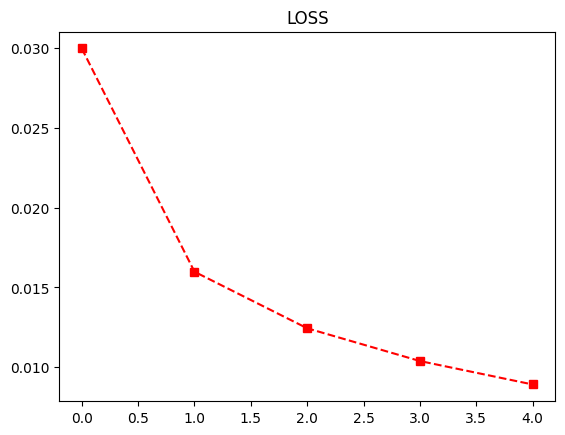

In [19]:
accuracy = accuracy_score(np.argmax(y_valid, axis=1), y_pred)
print(f'accuracy: {accuracy:.3f}')

plt.title('LOSS')
plt.plot(clf.log_loss, 'rs--')

## 【問題9】学習と推定

In [20]:
# スクラッチディープニューラルネットワーク (任意のレイヤーで実行できる場合)
class ScratchDNNClassifier():
    """
    N層ニューラルネットワーク分類器
    
    Parameters
    ----------
    self.n_epoch : エポック数
    self.n_batch : バッチ数
    self.verbose : 学習プロセスの可視化
    Attributes
    ----------
    """
    def __init__(self, NN, n_epoch, n_batch, verbose=False):
        # Parameters
        self.n_epoch = n_epoch
        self.n_batch = n_batch
        self.verbose = verbose
        self.log_loss = np.zeros(self.n_epoch)
        self.log_acc = np.zeros(self.n_epoch)
        self.NN = NN
        
    def loss_function(self, y, yt):
        delta = 1e-7
        return -np.mean(yt*np.log(y+delta))
    
    def accuracy(self, Z, Y):
        return accuracy_score(Y,Z)

    def fit(self, X, y, X_val=False, y_val=False):
        """
        ニューラル ネットワーク分類器をトレーニング

        Parameters
        ----------
        X : 次の形の ndarray、形状 (n_samples、n_features)
            訓練データの特徴
        y : 次の形の ndarray, shape (n_samples, )
            学習データの正解値
        X_val : 次の形の ndarray、形状 (n_samples、n_features)
            検証データの特徴
        y_val : 次の形の ndarray, shape (n_samples, )
            検証データの正しい値
        """
        for epoch in range(self.n_epoch):
            # ミニバッチ処理
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.n_batch)
            
            self.loss = 0
            for mini_X_train, mini_y_train in get_mini_batch:
                
                # フォワードプロパゲーション
                forward_data = mini_X_train
                for layer in range(len(self.NN)):
                    forward_data = self.NN[layer].forward(forward_data)
                # 予測値
                Z = forward_data
                
                # バックプロパゲーション
                backward_data = (Z - mini_y_train)/self.n_batch
                for layer in range(len(self.NN)-1,-1,-1):
                    backward_data = self.NN[layer].backward(backward_data)
                
                # 損失関数
                self.loss += self.loss_function(Z,mini_y_train)
                
            self.log_loss[epoch] = self.loss/len(get_mini_batch)
            self.log_acc[epoch] = self.accuracy(self.predict(X),np.argmax(y,axis=1))
            
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使用して推定

        Parameters
        ----------
        X : 次の形の ndarray、形状 (n_samples、n_features)
            サンプル

        Returns
        -------
            次の形の ndarray、形状 (n_samples, 1)
            推定結果
        """
        pred_data = X
        
        for layer in range(len(self.NN)):
            pred_data = self.NN[layer].forward(pred_data)
            
        return np.argmax(pred_data,axis=1)

### 検証１

In [21]:
NN2 = {
    0: FC(784, 200, HeInitializer(), AdaGrad(0.01), ReLU()),
    1: FC(200, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax())
}

clf2 = ScratchDNNClassifier(NN=NN2, n_epoch=30, n_batch=20, verbose=False)

clf2.fit(X_train, y_train)
y_pred2 = clf2.predict(X_valid)

C:\Users\ryoga_inaba\AppData\Local\Temp\ipykernel_18636\3602743907.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0] / self.batch_size).astype(np.int)
C:\Users\ryoga_inaba\AppData\Local\Temp\ipykernel_18636\3602743907.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to rev

accuracy: 0.967


C:\Users\ryoga_inaba\AppData\Local\Temp\ipykernel_18636\296956693.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


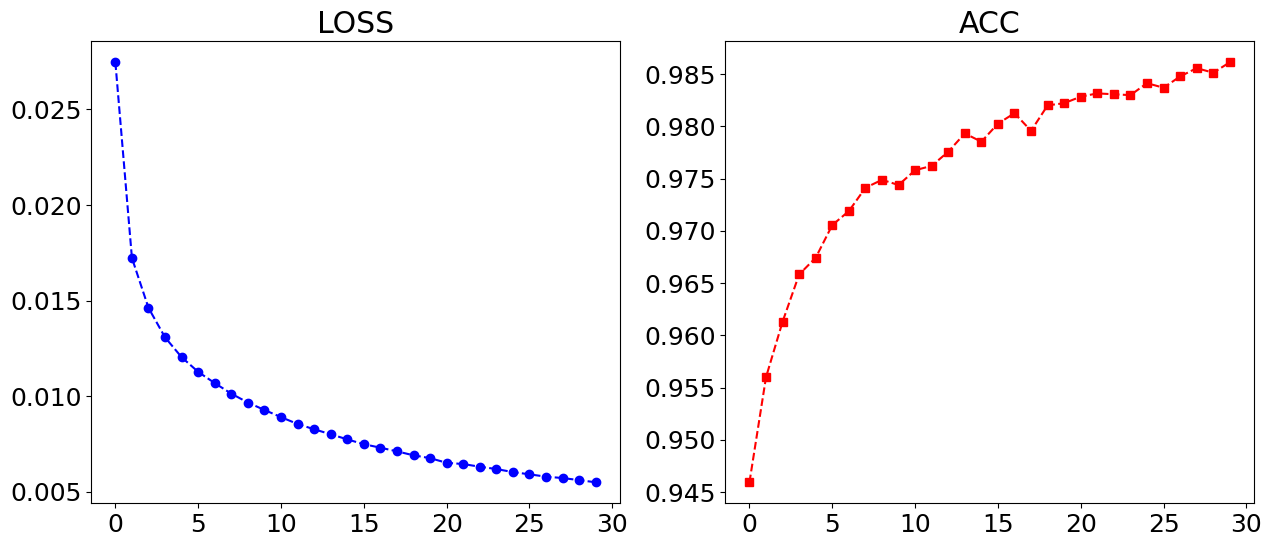

In [22]:
# Accuracy
accuracy = accuracy_score(np.argmax(y_valid, axis=1), y_pred2)
print(f'accuracy: {accuracy:.3f}')

# グラフ
plt.rcParams["font.size"] = 18
fig = plt.subplots(figsize=(15,6))

plt.subplot(1,2,1)
plt.title('LOSS')
plt.plot(clf2.log_loss, 'bo--')

plt.subplot(1,2,2)
plt.title('ACC')
plt.plot(clf2.log_acc, 'rs--')

### 検証２

In [23]:
NN3 = {
    0: FC(784, 200, XavierInitializer(), AdaGrad(0.01), Sigmoid()),
    1: FC(200, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax())
}

clf3 = ScratchDNNClassifier(NN=NN3, n_epoch=30, n_batch=20, verbose=False)

clf3.fit(X_train, y_train)
y_pred3 = clf3.predict(X_valid)

C:\Users\ryoga_inaba\AppData\Local\Temp\ipykernel_18636\3602743907.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0] / self.batch_size).astype(np.int)
C:\Users\ryoga_inaba\AppData\Local\Temp\ipykernel_18636\3602743907.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to rev

accuracy: 0.952


C:\Users\ryoga_inaba\AppData\Local\Temp\ipykernel_18636\2429380591.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


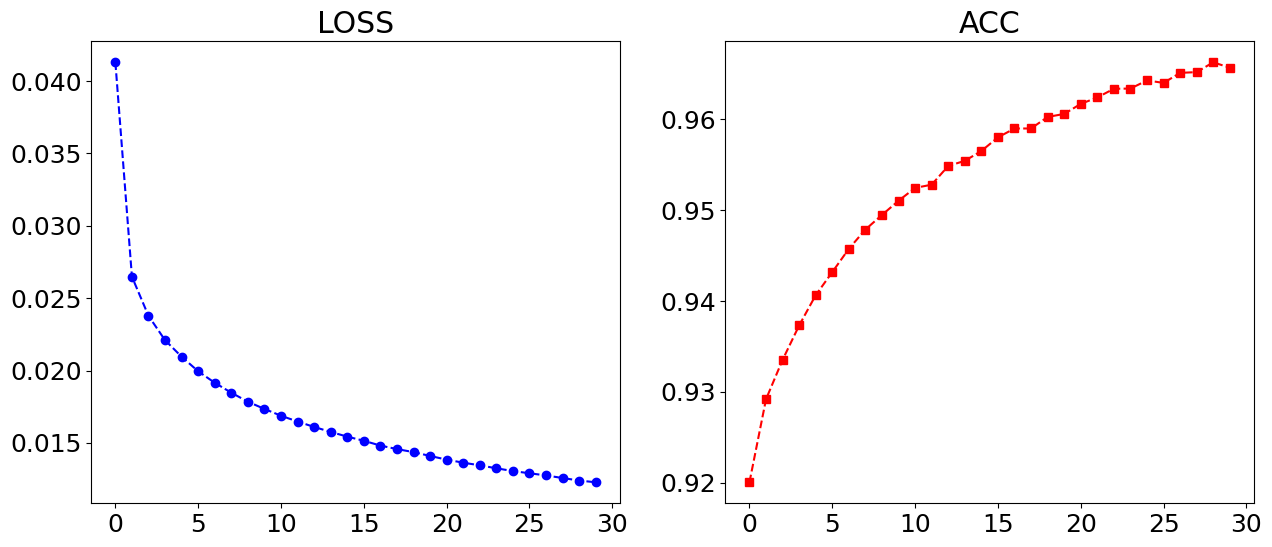

In [24]:
# Accuracy
accuracy = accuracy_score(np.argmax(y_valid, axis=1), y_pred3)
print(f'accuracy: {accuracy:.3f}')

# グラフ
plt.rcParams["font.size"] = 18
fig = plt.subplots(figsize=(15,6))

plt.subplot(1,2,1)
plt.title('LOSS')
plt.plot(clf3.log_loss, 'bo--')

plt.subplot(1,2,2)
plt.title('ACC')
plt.plot(clf3.log_acc, 'rs--')